In [1]:
import json, random
from pathlib import Path

import numpy as np
import torch

import os
os.chdir('..')
from utils.visualizer import SoccerVisualizer  # your class :contentReference[oaicite:1]{index=1}
from utils.static_maps import PitchStaticChannels

class MemmapShardCache:
    """
    Cache one shard in memory-mapped form.
    X: (N,C,H,W) float16
    T: (N,3)     float32
    """
    def __init__(self, out_root: str, split: str = "train", seed: int = 0):
        self.out_root = Path(out_root)
        self.split = split
        self.rng = random.Random(seed)

        split_dir = self.out_root / split
        manifest = json.loads((split_dir / "manifest.json").read_text())

        self.C = int(manifest["C"])
        self.H = int(manifest["H"])
        self.W = int(manifest["W"])
        self.channels = list(manifest["channels"])
        shards = list(manifest["shards"])
        if len(shards) == 0:
            raise RuntimeError(f"No shards in {split_dir}")

        shard = self.rng.choice(shards)
        self.N = int(shard["n"])

        x_path = split_dir / shard["x_path"]
        t_path = split_dir / shard["t_path"]

        self.X = np.memmap(x_path, mode="r", dtype=np.float16, shape=(self.N, self.C, self.H, self.W))
        self.T = np.memmap(t_path, mode="r", dtype=np.float32, shape=(self.N, 3))

        self.split_dir = split_dir
        self.shard_x_path = x_path

        print(f"[cache] split={split} shard={x_path.name} N={self.N} C={self.C} H={self.H} W={self.W}")

    def get(self, sample_idx: int | None = None):
        if sample_idx is None:
            sample_idx = self.rng.randrange(self.N)
        x_chw = torch.from_numpy(self.X[sample_idx].astype(np.float32, copy=False))  # (C,H,W)
        t_3 = torch.from_numpy(self.T[sample_idx].astype(np.float32, copy=False))   # (3,)
        return sample_idx, x_chw, t_3


## Show every channel

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def show_all_channels_one_figure(
    cache: MemmapShardCache,
    static: torch.nn.Module | None = None,
    sample_idx: int | None = None,
    *,
    max_cols: int = 6,
    cmap=None,
    overlay_players: bool = True,
):
    """
    Shows every channel (dynamic + optional static) in one grid figure.

    Inputs:
      cache: MemmapShardCache (loads one shard once)
      static: PitchStaticChannels instance (optional). If provided, its channels are appended.
      sample_idx: if None, picks random index from the loaded shard

    Output:
      Displays a single matplotlib figure.
    """
    idx, X_dyn, t_3 = cache.get(sample_idx)  # X_dyn: (C_dyn,H,W)

    # --- build full channel stack
    names = list(cache.channels)
    X = X_dyn

    if static is not None:
        # static.forward() -> (C_static,H,W)
        X_stat = static.forward().to(dtype=X_dyn.dtype, device=X_dyn.device)
        X = torch.cat([X_dyn, X_stat], dim=0)

        # names in same order as PitchStaticChannels.forward()
        names += ["boundary_dist_norm", "centerline_dist_norm", "goal_sin", "goal_cos", "goal_dist_norm"]

    C_total, H, W = X.shape

    # --- pick player overlays if present
    # Assumes atk/def one-hot exist in your dynamic channels list; if not, overlays disabled.
    in_pos = out_pos = None
    if overlay_players:
        try:
            i_atk = names.index("atk_team_1hot")
            i_def = names.index("def_team_1hot")
            in_pos = X[i_atk]
            out_pos = X[i_def]
        except ValueError:
            overlay_players = False

    # --- visualizer
    viz = SoccerVisualizer(pitch_length=H, pitch_width=W, layout="x_rows")  # :contentReference[oaicite:2]{index=2}

    ncols = min(max_cols, C_total)
    nrows = int(np.ceil(C_total / ncols))

    fig = plt.figure(figsize=(4.3 * ncols, 3.0 * nrows))
    fig.suptitle(
        f"{cache.split} | shard={cache.shard_x_path.name} | sample={idx} "
        f"| end=({t_3[0]:.1f},{t_3[1]:.1f}) succ={int(t_3[2].item())}",
        fontsize=14,
    )

    # --- render each channel on its own pitch subplot
    for c in range(C_total):
        ax = fig.add_subplot(nrows, ncols, c + 1)

        heat = X[c]

        if overlay_players and (in_pos is not None) and (out_pos is not None):
            viz.plot_state(
                in_possession=in_pos,
                out_possession=out_pos,
                heatmap=heat,
                ax=ax,
                add_colorbar=False,
                edgecolors="none",
                show_voronoi=False,
            )
        else:
            viz.plot_heatmap(
                heat,
                ax=ax,
                draw=False,   # no per-axis colorbar
                edgecolors="none",
            )

        ax.set_title(f"[{c:02d}] {names[c]}", fontsize=10)

    # blank unused
    for k in range(C_total, nrows * ncols):
        ax = fig.add_subplot(nrows, ncols, k + 1)
        ax.axis("off")

    plt.tight_layout(rect=[0, 0.02, 1, 0.95])
    plt.show()

    return idx, names


In [3]:
cache = MemmapShardCache(out_root="data/finaldata-3meter", split="train", seed=0)
static = PitchStaticChannels()

[cache] split=train shard=X_shard_0006.mmap N=10000 C=13 H=105 W=68


/tmp/ipykernel_105428/3505102340.py:52: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  t_3 = torch.from_numpy(self.T[sample_idx].astype(np.float32, copy=False))   # (3,)


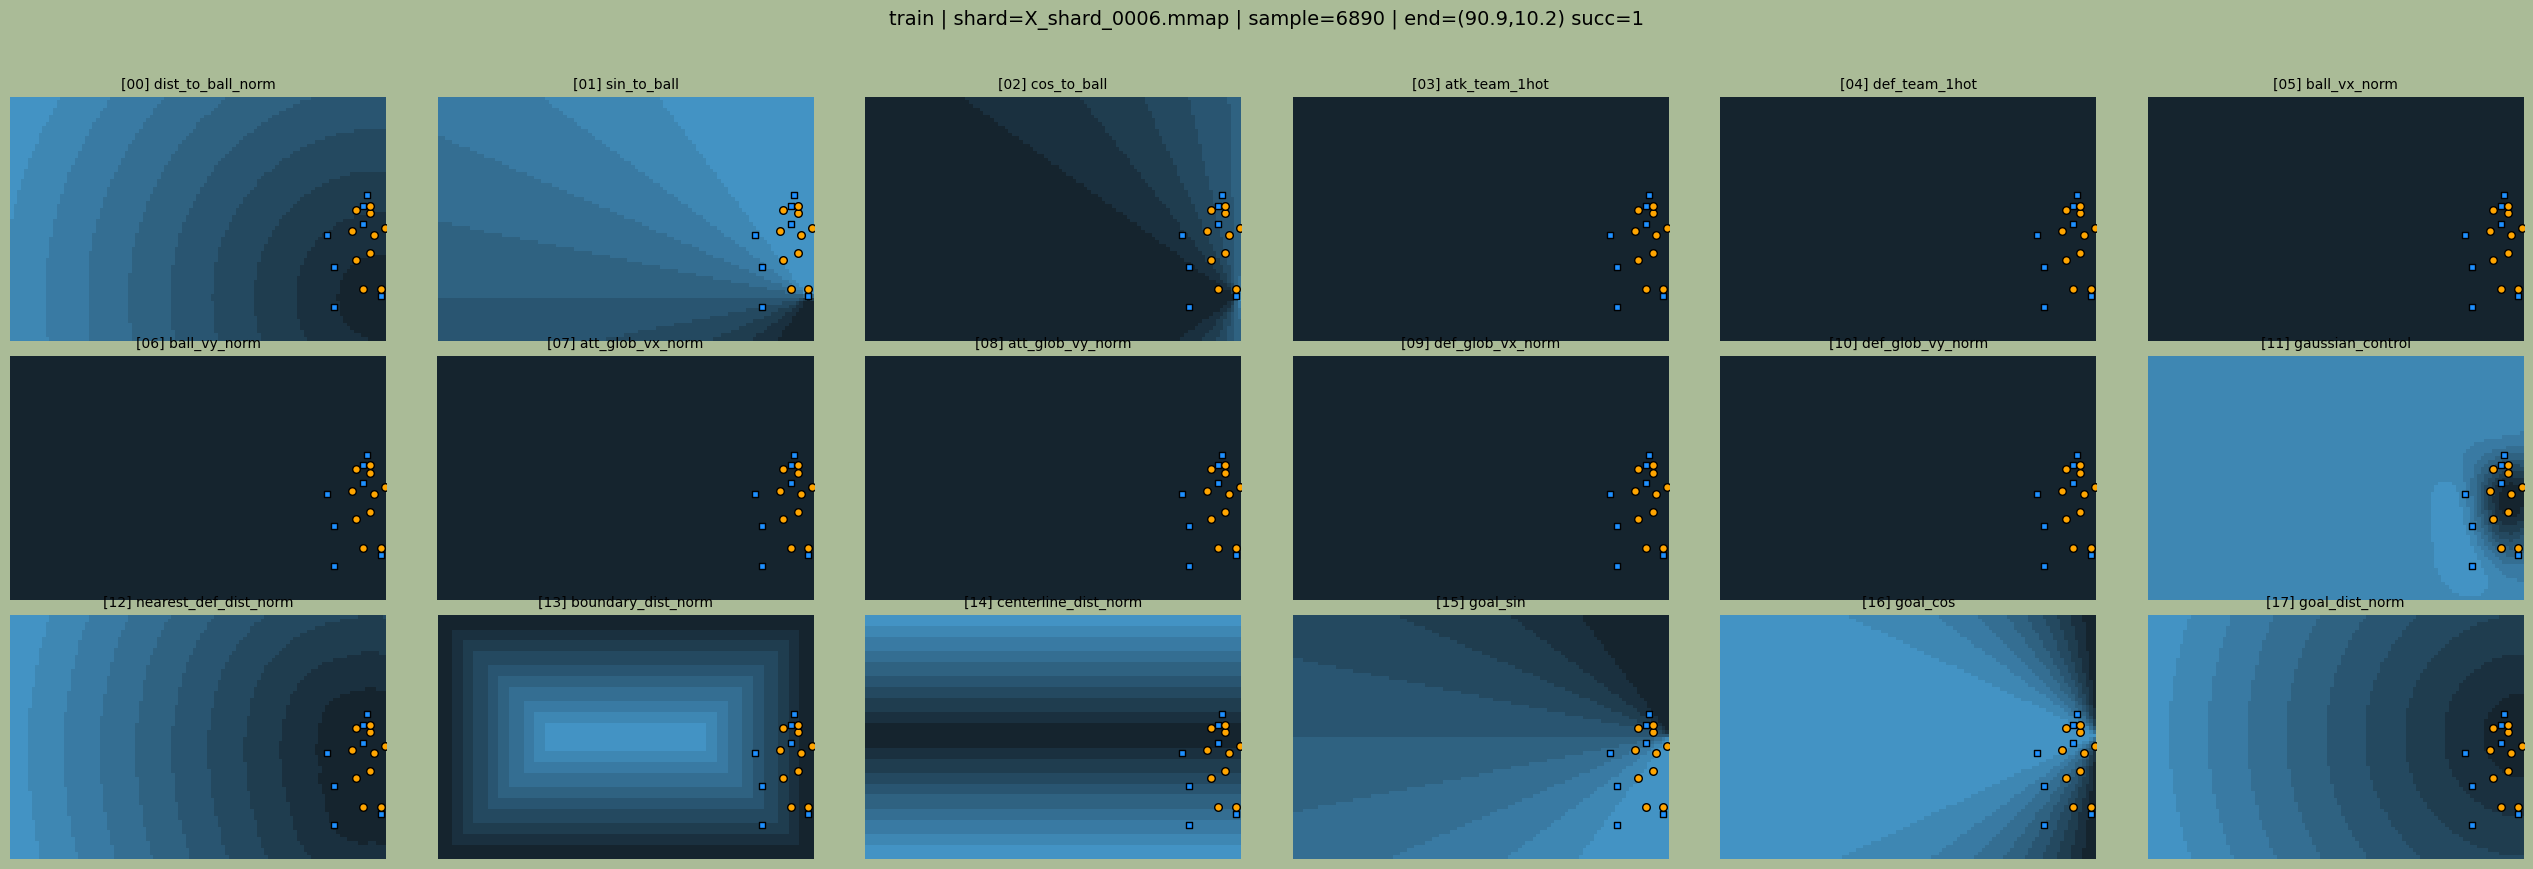

(6890,
 ['dist_to_ball_norm',
  'sin_to_ball',
  'cos_to_ball',
  'atk_team_1hot',
  'def_team_1hot',
  'ball_vx_norm',
  'ball_vy_norm',
  'att_glob_vx_norm',
  'att_glob_vy_norm',
  'def_glob_vx_norm',
  'def_glob_vy_norm',
  'gaussian_control',
  'nearest_def_dist_norm',
  'boundary_dist_norm',
  'centerline_dist_norm',
  'goal_sin',
  'goal_cos',
  'goal_dist_norm'])

In [4]:

show_all_channels_one_figure(cache, static=static)
#show_all_channels_one_figure(cache, static=static, sample_idx=123)